In [ ]:
#%pip install selenium
#%pip install bs4
#%pip install pandas
#%pip install requests
#%pip install tqdm
#%pip install ipywidgets
#%jupyter nbextension enable --py widgetsnbextension
#%pip install sweetviz
#%pip install seaborn
#%pip install -U scikit-learn


<h2> Imports </h2>

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import numpy as np
import time
import pandas as pd
from tqdm.notebook import tqdm, trange
import threading 
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from IPython.display import Javascript
from nbconvert import HTMLExporter

<h2> Global Helper Functions </h2>

<p>These functions were primarliy used for the crawling phase of the project, mainly for cacheing the html pages</p>


In [2]:
def cache_str(file_name: str, text: str):
    try:
        with open(f'./cache/{file_name}', 'wb') as file:
            file.write(text.encode('utf-8'))
    except Exception as e:
        print("Could not save file..", e)

def cache_strings(file_name: str, text: list[str]):
    try:
        with open(f'./cache/{file_name}', 'wb') as file:
            for t in text:
                file.write(t.encode('utf-8'))
    except Exception as e:
        print("Could not save file..", e)

def load_str(file_name: str):
    text = None
    try:
        with open(f'./cache/{file_name}', 'rb') as file:
            text = file.read().decode()
    except Exception as e:
        print("Could not find/load file", e)
    return text

def get_properties(page_number: int, html: str, city: str) -> list[str]:
    soup = BeautifulSoup(html, 'html.parser')
    links = []
    for p in soup.select(selectors.property_selector):
        links.append(get_property_link(p))
    return links
    
def get_property_link(prop: BeautifulSoup):
    return prop.select_one(selectors.property_link)['href']

    
def get_all_cities_links():
    allLinks = set()
    for city in cities:
        for i in range(0,40):
            tempLinks = get_properties(i, load_str(f"{city}_{i+1}.html"), city)
            for j in range(0,25):
                allLinks.add(tempLinks[j])
            i = i + 1
    return allLinks


def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

<h2>Dictionaries for Crawling </h2>

<p>We have found a trick to access dictionary values with a dot, as if it were a class variable in a different programming language</p>

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

selectors = {
    'property_selector': "div[data-testid*=\"property-card\"]",
    'property_title': "div[data-testid*=\"title\"]",
    'property_link': "a[data-testid=\"title-link\"]",
    'page_title' : "div[id=\"wrap-hotelpage-top\"]",
    'next_page' : "button[aria-label=\"Next page\"]"
}

cities = {
    'Rome' : "https://www.booking.com/searchresults.html?aid=397594&label=gog235jc-1DCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIE4AIB&sid=8be5ab11ebf56d2d924feee13ee069f4&sb=1&sb_lp=1&src=index&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Findex.html%3Faid%3D397594%3Blabel%3Dgog235jc-1DCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIE4AIB%3Bsid%3D8be5ab11ebf56d2d924feee13ee069f4%3Bsb_price_type%3Dtotal%26%3B&ss=Rome%2C+Lazio%2C+Italy&is_ski_area=&checkin_year=&checkin_month=&checkout_year=&checkout_month=&group_adults=2&group_children=0&no_rooms=1&b_h4u_keep_filters=&from_sf=1&ss_raw=rome&ac_position=0&ac_langcode=en&ac_click_type=b&dest_id=-126693&dest_type=city&iata=ROM&place_id_lat=41.89587&place_id_lon=12.482617&search_pageview_id=68058008b3d000d4&search_selected=true&search_pageview_id=68058008b3d000d4&ac_suggestion_list_length=5&ac_suggestion_theme_list_length=0",
    'Venice' : "https://www.booking.com/searchresults.html?aid=397594&label=gog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB&sid=8be5ab11ebf56d2d924feee13ee069f4&sb=1&src=searchresults&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Fsearchresults.html%3Faid%3D397594%3Blabel%3Dgog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB%3Bsid%3D8be5ab11ebf56d2d924feee13ee069f4%3Btmpl%3Dsearchresults%3Bcity%3D-126693%3Bclass_interval%3D1%3Bdest_id%3D-126693%3Bdest_type%3Dcity%3Bdtdisc%3D0%3Bfrom_sf%3D1%3Bgroup_adults%3D2%3Bgroup_children%3D0%3Binac%3D0%3Bindex_postcard%3D0%3Blabel_click%3Dundef%3Bno_rooms%3D1%3Boffset%3D0%3Bpostcard%3D0%3Broom1%3DA%252CA%3Bsb_price_type%3Dtotal%3Bshw_aparth%3D1%3Bslp_r_match%3D0%3Bsrc%3Dsearchresults%3Bsrc_elem%3Dsb%3Bsrpvid%3Dbd40552bf217017e%3Bss%3DVenice%3Bss_all%3D0%3Bss_raw%3DRomeVen%3Bssb%3Dempty%3Bsshis%3D0%3Bssne%3DRome%3Bssne_untouched%3DRome%26%3B&ss=Venice%2C+Veneto%2C+Italy&is_ski_area=&ssne=Rome&ssne_untouched=Rome&city=-126693&checkin_year=&checkin_month=&checkout_year=&checkout_month=&group_adults=2&group_children=0&no_rooms=1&from_sf=1&ss_raw=Venice&ac_position=0&ac_langcode=en&ac_click_type=b&dest_id=-132007&dest_type=city&iata=VCE&place_id_lat=45.43389&place_id_lon=12.338505&search_pageview_id=bd40552bf217017e&search_selected=true&search_pageview_id=bd40552bf217017e&ac_suggestion_list_length=5&ac_suggestion_theme_list_length=0",
    'Florence' : "https://www.booking.com/searchresults.html?aid=397594&label=gog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB&sid=8be5ab11ebf56d2d924feee13ee069f4&sb=1&src=searchresults&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Fsearchresults.html%3Faid%3D397594%3Blabel%3Dgog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB%3Bsid%3D8be5ab11ebf56d2d924feee13ee069f4%3Btmpl%3Dsearchresults%3Bac_click_type%3Db%3Bac_position%3D0%3Bcity%3D-126693%3Bclass_interval%3D1%3Bdest_id%3D-132007%3Bdest_type%3Dcity%3Bdtdisc%3D0%3Bfrom_sf%3D1%3Bgroup_adults%3D2%3Bgroup_children%3D0%3Biata%3DVCE%3Binac%3D0%3Bindex_postcard%3D0%3Blabel_click%3Dundef%3Bno_rooms%3D1%3Boffset%3D0%3Bpostcard%3D0%3Braw_dest_type%3Dcity%3Broom1%3DA%252CA%3Bsb_price_type%3Dtotal%3Bsearch_selected%3D1%3Bshw_aparth%3D1%3Bslp_r_match%3D0%3Bsrc%3Dsearchresults%3Bsrc_elem%3Dsb%3Bsrpvid%3Dd36b5530c0d602ac%3Bss%3DVenice%252C%2520Veneto%252C%2520Italy%3Bss_all%3D0%3Bss_raw%3DVenice%3Bssb%3Dempty%3Bsshis%3D0%3Bssne%3DRome%3Bssne_untouched%3DRome%26%3B&ss=Florence%2C+Tuscany%2C+Italy&is_ski_area=&ssne=Venice&ssne_untouched=Venice&city=-132007&checkin_year=&checkin_month=&checkout_year=&checkout_month=&group_adults=2&group_children=0&no_rooms=1&from_sf=1&ss_raw=Florence&ac_position=0&ac_langcode=en&ac_click_type=b&dest_id=-117543&dest_type=city&iata=FLR&place_id_lat=43.771427&place_id_lon=11.254021&search_pageview_id=d36b5530c0d602ac&search_selected=true&search_pageview_id=d36b5530c0d602ac&ac_suggestion_list_length=5&ac_suggestion_theme_list_length=0",
    'Naples' : "https://www.booking.com/searchresults.html?aid=397594&label=gog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB&sid=8be5ab11ebf56d2d924feee13ee069f4&sb=1&src=searchresults&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Fsearchresults.html%3Faid%3D397594%3Blabel%3Dgog235jc-1FCAEoggI46AdIM1gDaGqIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ApHtt44GwAIB0gIkZDRkMGVhNDMtY2FmMC00MWI1LWI1ZTktNjMwMGY5YjRlZTA42AIF4AIB%3Bsid%3D8be5ab11ebf56d2d924feee13ee069f4%3Btmpl%3Dsearchresults%3Bcity%3D-117543%3Bclass_interval%3D1%3Bdest_id%3D-117543%3Bdest_type%3Dcity%3Bdtdisc%3D0%3Bfrom_sf%3D1%3Bgroup_adults%3D2%3Bgroup_children%3D0%3Binac%3D0%3Bindex_postcard%3D0%3Blabel_click%3Dundef%3Bno_rooms%3D1%3Boffset%3D0%3Bpostcard%3D0%3Broom1%3DA%252CA%3Bsb_price_type%3Dtotal%3Bshw_aparth%3D1%3Bslp_r_match%3D0%3Bsrc%3Dsearchresults%3Bsrc_elem%3Dsb%3Bsrpvid%3De982553e55b4019b%3Bss%3DNaples%3Bss_all%3D0%3Bssb%3Dempty%3Bsshis%3D0%3Bssne%3DFlorence%3Bssne_untouched%3DFlorence%26%3B&ss=Naples%2C+Campania%2C+Italy&is_ski_area=&ssne=Florence&ssne_untouched=Florence&city=-117543&checkin_year=&checkin_month=&checkout_year=&checkout_month=&group_adults=2&group_children=0&no_rooms=1&from_sf=1&ss_raw=Naples&ac_position=0&ac_langcode=en&ac_click_type=b&dest_id=-122902&dest_type=city&iata=NAP&place_id_lat=40.84304&place_id_lon=14.251333&search_pageview_id=e982553e55b4019b&search_selected=true&search_pageview_id=e982553e55b4019b&ac_suggestion_list_length=5&ac_suggestion_theme_list_length=0"
}

dataSelectorsBoolean = {
    'Free WiFi': "svg[class=\"bk-icon -iconset-wifi hp__important_facility_icon\"]",
    'Airport Shuttle': "svg[class=\"bk-icon -iconset-shuttle hp__important_facility_icon\"]",
    'Restaurant': "svg[class=\"bk-icon -iconset-food hp__important_facility_icon\"]",
    'Private Parking': "svg[class=\"bk-icon -iconset-parking_sign hp__important_facility_icon\"]",
    'Bar': "svg[class=\"bk-icon -iconset-bar hp__important_facility_icon\"]",
    'Non Smoking Rooms': "svg[class=\"bk-icon -iconset-nosmoking hp__important_facility_icon\"]",
    'Pet Friendly': "svg[class=\"bk-icon -iconset-pawprint hp__important_facility_icon\"]",
    'Elevator': "svg[class=\"bk-icon -iconset-elevator hp__important_facility_icon\"]",
}

dataSelectorsText =  {
    'Hotel Name': "a[id=\"hp_hotel_name_reviews\"]",
    'Rating': "#guest-featured_reviews__horizontal-block > div > div.hp_review_score_entry > a > div > div > div > div > div:first-child",
    'Distance From Airport': "#basiclayout > div.k2-property_page--layout.k2-hp_full-width--layout > div > div.bui-grid__column.bui-grid__column-12.js-k2-hp--block.k2-hp--location_surroundings > div > div.hp_location_block__content_container > div.hp_location_block__section_container.transport_airport > ul > li > div > div.bui-list__item-action.hp_location_block__section_list_distance",
}



selectors = dotdict(selectors)
cities = dotdict(cities)
dataSelectorsBoolean = dotdict(dataSelectorsBoolean)
dataSelectorsText = dotdict(dataSelectorsText)

<h2>Selenium Crawling Functions </h2>

In [6]:
def crawl_pages():
    driver = webdriver.Chrome(executable_path=r'.\geckodriver\geckodriver.exe')
    try:
        for city in cities:
            CityLink = cities.get(city)

            for page in range(1,41):
                driver.get(CityLink)
                WebDriverWait(driver, timeout=10, poll_frequency=1).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, selectors.property_selector))
                )
                html = driver.find_element_by_xpath("//body").get_attribute('outerHTML')
                cache_str(f'{city}_{page}.html', html)

                
                nxt = driver.find_element_by_css_selector(selectors.next_page)
                nxt.click()
                time.sleep(1)
                CityLink = driver.current_url
                
    finally:
        driver.quit()

def crawl_data_pages():
    driver = webdriver.Chrome(executable_path=r'.\geckodriver\geckodriver.exe')
    try:
        i = 1
        for link in allLinks:
            driver.get(link)
            WebDriverWait(driver, timeout=10, poll_frequency=1).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, selectors.page_title))
            )
            html = driver.find_element_by_xpath("//body").get_attribute('outerHTML')
            cache_str(f'data_{i}.html', html)
            i = i + 1
                
    finally:
        driver.quit()


In [ ]:
crawl_pages()
allLinks = get_all_cities_links()
crawl_data_pages()

<h2> Fetch Dataframe Data From Cache</h2>

<p>This function takes a certain batch of cached html pages (for example page #100 to page #200) and using BeautifulSoup we grab the data using CSS selectors and append them to our dictionary that would eventually be made into a dataframe</p>

In [7]:
def get_df_data(batch_number_floor: int,batch_number_cieling: int ):
    dataframeColumns = { 'Hotel Name': [],
                'Rating' : [],
                'Rating Group' : [], 
                'Free WiFi' : [], 
                 'Airport Shuttle': [], 
                 'Distance From Airport':[],
                 'Restaurant':[],
                 'Private Parking':[],
                 'Bar':[],
                 'Non Smoking Rooms':[],
                 'Pet Friendly' : [],
                 'Elevator' : []}


    for i in trange(batch_number_floor , batch_number_cieling):
        try:
            html = load_str(f"data_{i}.html")
            soup = BeautifulSoup(html, 'html.parser')
            for col in dataSelectorsBoolean:
                dataframeColumns[col].append(bool(soup.select(dataSelectorsBoolean[col])))
            for col in dataSelectorsText:
                if(col == 'Rating'):
                    dataframeColumns[col].append(getattr(soup.select_one(dataSelectorsText[col]),'text', "0.0").split(" ")[0])
                else:
                    dataframeColumns[col].append(soup.select_one(dataSelectorsText[col]).text.strip())
        except Exception as e:
            print(i,e)

    dataframeColumns['Distance From Airport'] = [float(distance.split(" ")[0]) for distance in dataframeColumns['Distance From Airport']]
    dataframeColumns["Rating"] = list(np.float_(dataframeColumns["Rating"]))

    for index,rate in enumerate(dataframeColumns['Rating']):
            if(rate==0):
                dataframeColumns['Rating Group'].append(0.0)
            elif(rate >= 0.1 and rate <= 3.5):
                dataframeColumns['Rating Group'].append(1.0)
            elif(rate >= 3.6 and rate <= 7.5):
                dataframeColumns['Rating Group'].append(2.0)
            elif(rate >= 7.6 and rate <= 10.0):
                dataframeColumns['Rating Group'].append(3.0)
            

    return dataframeColumns



<p>In this section, the main challenge was the sheer number of cached html pages and the time it took to crawl them and get the relevant data we needed.
To overcome this challenge, we have used multithreading and split the cached pages into batches where each thread was responsible of the crawling.
After each crawl was done, each thread returned his own version of a dictionary where eventually our helper function of merging dictionaries merged them all together on the main thread and save it as a dataframe and a CSV file</p>

In [8]:
def retrieve_in_batches():
    tempDF = pd.DataFrame()
    for i in trange(1,5):
        try:
            tempDF.append(get_df_data((i-1)*1000 ,i*1001)) 
        except Exception as e:
             print(e)
    return tempDF.to_csv("Hotel Data.csv") 


def merge_Dicts(mainDict : dict, tempDict: dict):
    try:
        for key in mainDict:
            for value in tempDict[key]:
                mainDict[key].append(value)
    except Exception as e:
        print(f"We are on column {key}, and its not iterable! ERROR: {e}")

def retrieve_in_batches_async():
    finalDataDict = {'Hotel Name': [],
                'Rating' : [],
                'Rating Group' : [], 
                'Free WiFi' : [], 
                 'Airport Shuttle': [],
                 'Distance From Airport':[],
                 'Restaurant':[],
                 'Private Parking':[],
                 'Bar':[],
                 'Non Smoking Rooms':[],
                 'Pet Friendly' : [],
                 'Elevator' : []}

    thread1Dict = {}
    thread2Dict = {}
    thread3Dict = {}
    thread4Dict = {}

    try:
        t1 = threading.Thread(target = lambda:thread1Dict.update(get_df_data(1 ,1001)), args=())
        t1.start()
        t2 = threading.Thread(target = lambda:thread2Dict.update(get_df_data(1001 ,2001)), args=())
        t2.start()
        t3 = threading.Thread(target = lambda:thread3Dict.update(get_df_data(2001 ,3001)), args=())
        t3.start()
        t4 = threading.Thread(target = lambda:thread4Dict.update(get_df_data(3001 ,4000)), args=())
        t4.start()

        t1.join()
        t2.join()
        t3.join()
        t4.join()

        t1 = threading.Thread(target = merge_Dicts(finalDataDict,thread1Dict), args=(finalDataDict,thread1Dict))
        t1.start()
        t2 = threading.Thread(target = merge_Dicts(finalDataDict,thread2Dict), args=(finalDataDict,thread2Dict))
        t2.start()
        t3 = threading.Thread(target = merge_Dicts(finalDataDict,thread3Dict), args=(finalDataDict,thread3Dict))
        t3.start()
        t4 = threading.Thread(target = merge_Dicts(finalDataDict,thread4Dict), args=(finalDataDict,thread4Dict))
        t4.start()

        t1.join()
        t2.join()
        t3.join()
        t4.join()

        df = pd.DataFrame(finalDataDict)
        df.to_csv("Hotel Data.csv")

    except Exception as e:
        print(e)
    

In [ ]:
retrieve_in_batches_async()

<h3>Hotel Data inside a table</h3>

In [9]:
df = pd.read_csv("Hotel Data.csv", low_memory=False)

<h4>Removing extra columns that were produced by loading from csv and dropping duplicate rows </h4>

In [10]:
df2 = df.copy()
df2.drop(columns='Unnamed: 0', inplace=True)
df2.drop_duplicates()
df2

,Hotel Name,Rating,Rating Group,Free WiFi,Airport Shuttle,Distance From Airport,Restaurant,Private Parking,Bar,Non Smoking Rooms,Pet Friendly,Elevator
0,Domus Donnaregina Apartments,9.3,3.0,True,False,3.3,False,False,False,True,False,False
1,Hotel Relais Il Cestello,8.6,3.0,True,False,4.9,False,True,True,True,False,False
2,Sleep & Zupp Casa Olimpia,9.3,3.0,True,True,4.4,False,True,False,True,True,False
3,Barbarella SPA,9.0,3.0,True,True,4.5,False,False,False,True,False,True
4,palazzo suite ducale,9.1,3.0,True,False,7.5,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3994,La Casa di Luna,9.2,3.0,True,True,3.1,False,True,False,True,True,False
3995,B&B Mr. My Resort,9.4,3.0,True,True,5.1,False,False,False,True,False,False
3996,Al Theatro Palace,9.2,3.0,True,True,7.9,False,False,True,True,False,False
3997,Casa Colonna Ricci,9.5,3.0,True,False,5.4,False,False,False,True,False,True


<h3>EDA and Data Analysis</h3>
<p>firstly, let us see the amount of hotels in each rating group</p>

<AxesSubplot:>

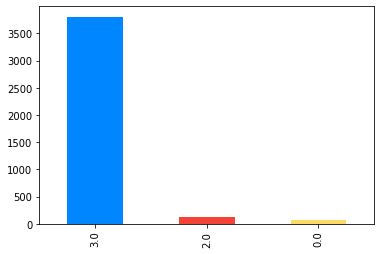

In [11]:
colors = ["#0086ff", "#f44336","#ffd966"]
df2['Rating Group'].value_counts().plot(kind='bar', color = colors)

<p>According to this bar plot, we can see that no hotel recieved the group rating of 1 (hotels between ratings of 0.1 to 3.9).</p>
<p>Most of the italian hotels are pretty good.. But why do we have some hotels that recieved a rating group of 0? Because we can assume
that new entries into the booking.com website take time recieving feedback from customers and as such are not given a rating untill much later</p>

<p>We will split the rating group of 3 into more sub groups to get a more accurate information.</p>
<p>We could understand what differentiates a hotel who recieved an overwhelmingly positive rating (for example: over 9.5)
and an hotel that recieved a very good rating (for example: 8.5)</p>

In [ ]:
for index,rating in enumerate(df2['Rating']):
    if (rating >= 7.6 and rating <= 8.6):
        df2['Rating Group'][index] = 3.0
    if (rating >= 8.7 and rating <= 9.6):
        df2['Rating Group'][index] = 4.0
    if (rating >= 9.7 and rating <= 10.0):
        df2['Rating Group'][index] = 5.0


<p>Now, check again which hotel belongs to what rating group</p>

<AxesSubplot:>

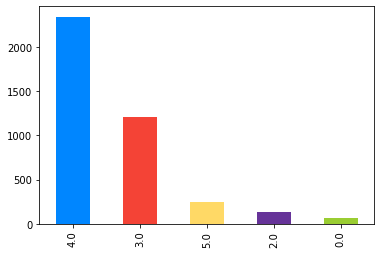

In [13]:
colors = ["#0086ff", "#f44336","#ffd966", "#663399", "#9ACD32"]
df2['Rating Group'].value_counts().plot(kind='bar', color = colors)

<h4>Let us check whether there is a correlation between the rating a hotel recieved and the distance from the airport! </h4>
<p>Our intuition is the closer to the airport, the higher the rating...</p>

<AxesSubplot:xlabel='Distance From Airport', ylabel='Rating'>

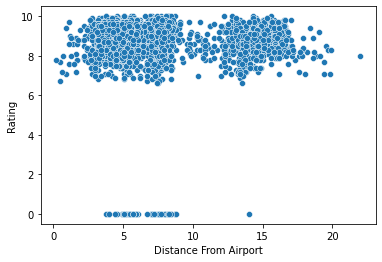

In [14]:
sns.scatterplot(data = df2, x='Distance From Airport', y='Rating')

<p>Another way of looking at it:</p>

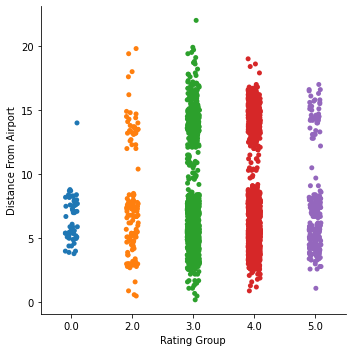

In [15]:
sns.catplot(x="Rating Group", y="Distance From Airport", data=df2)

<p>We can see that there is no special relation between the distance and the rating, the hotels that are further away from the airport recieved
similar scores to hotels near an aiport</p>
<h3>Another intersting topic is whether or not we can bring our pets with us!</h3>
<p>How many hotels are pet friendly?</p>

<AxesSubplot:xlabel='Pet Friendly', ylabel='count'>

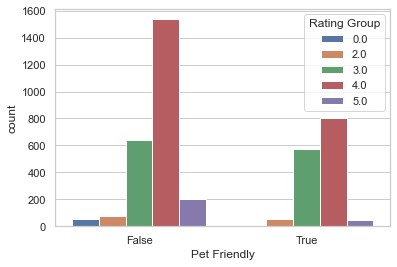

In [16]:
sns.set_theme(style='whitegrid')
sns.countplot(x='Pet Friendly', data=df2, hue='Rating Group')

<p>Surprisingly, many high-rated hotels do not allow pets...</p>
<p>Let us check whether or not there is a correlation between pet friendly hotels, their ratings and distance from airport!</p>

                       Pet Friendly    Rating  Distance From Airport
Pet Friendly               1.000000 -0.041098              -0.043930
Rating                    -0.041098  1.000000               0.000177
Distance From Airport     -0.043930  0.000177               1.000000


<AxesSubplot:>

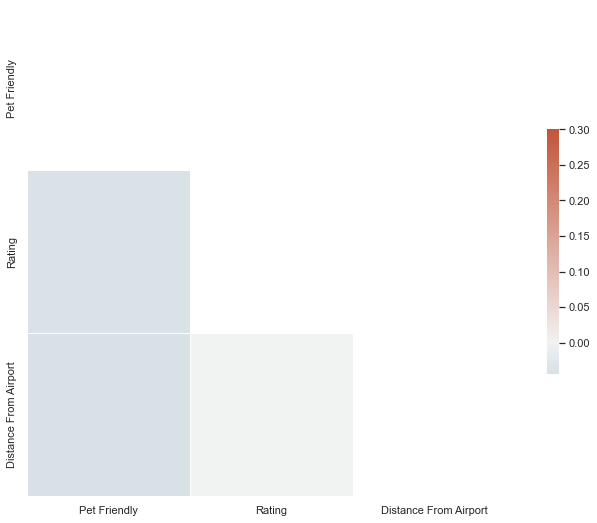

In [22]:
sns.set_theme(style="white")
pets_rate_distance = df2[["Pet Friendly","Rating","Distance From Airport"]]

corr = pets_rate_distance.corr(method='pearson')
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


<p>From this heat-map we can infer that there is a weak connection between these 3 columns.</p>
<p>So bringing your pet from a distant airport doesnt affect hotel rating afterall...</p>
<p>Lets check our entire dataset and everyone columns correlation with eachother.</p>

<AxesSubplot:>

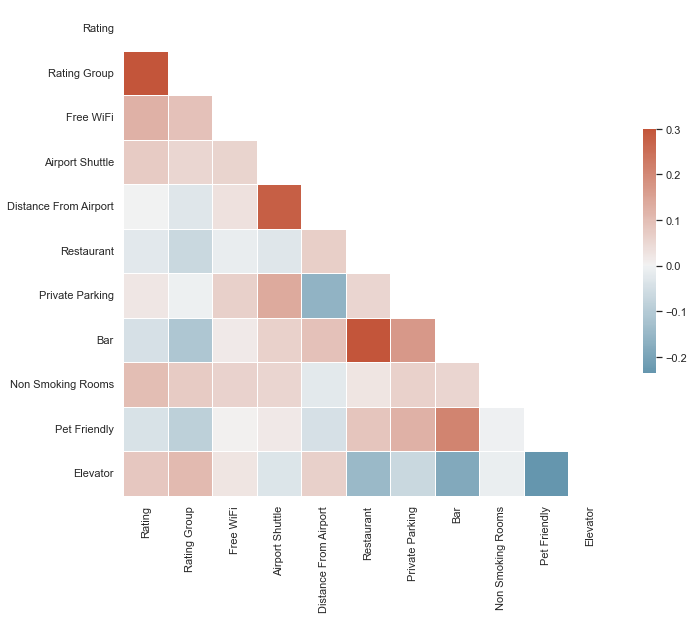

In [18]:
sns.set_theme(style="white")
corr = df2.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<p>Now according to this heat map, there is a correlation between distance from airport and an hotel having a airport shuttle</p>
<p>Lets take a look at the distribution of the hotels and their distance from the airport</p>

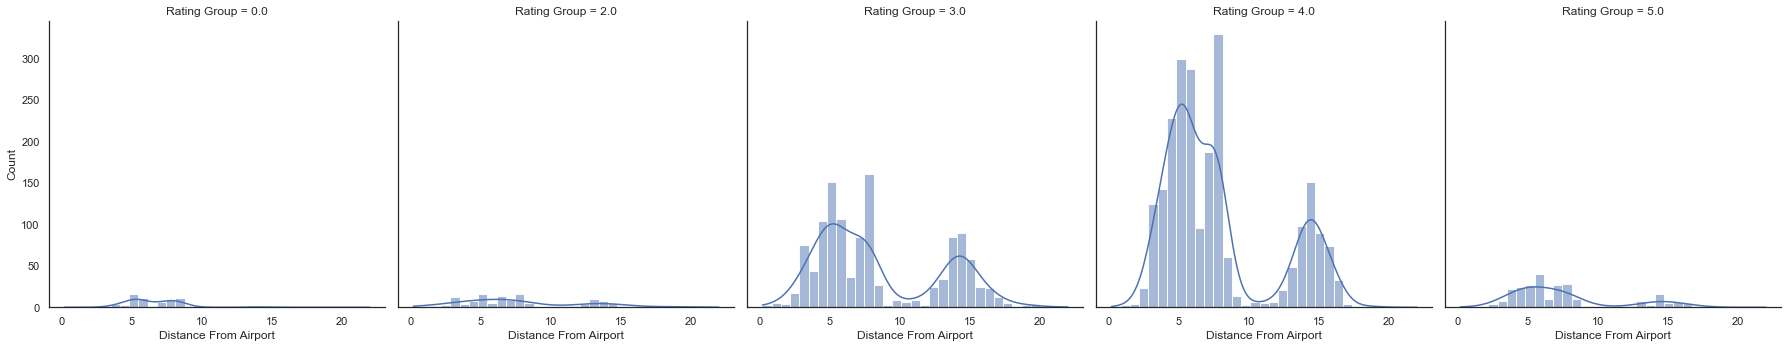

In [19]:
sns.displot(data=df2, x="Distance From Airport", col="Rating Group", kde=True)

<p>We can see that the very best hotels (rated 9.5 and above) are actually closer to the airport!</p>

In [24]:
X = df2.drop(['Rating Group','Hotel Name','Rating'],axis=1).values   # independant features
y = df['Rating Group'].values					                     # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=42)
model = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)

def predict(classifier, X_test, y_test):
    return pd.DataFrame({"Actual":y_test,"Predicted":classifier.predict(X_test)})


df_model = predict(model,X_test,y_test)

print('Accuracy on training data= ', metrics.accuracy_score(y_true = df_model['Actual'], y_pred = df_model['Predicted']))


Accuracy on training data=  0.9533333333333334


In [25]:
save_notebook()
time.sleep(3)
current_file = 'PythonHotelProject.ipynb'
output_file = 'HotelProjectPythonHIT.html'
output_HTML(current_file, output_file)

<h1>Conclusions</h1>

<p>We have attempted to predict what rating a hotel might recieve and our model has been able to do so with 95% accuracy!</p>
<p>Hotel experience in general is a subjective matter, one might enjoy the hotel very much and the attractions it has and another person would dislike it greatly. Despite what we have said there are general guide lines that can decide whether an hotel is considered good and we can see that in our research. Also, we did comeup with interesting facts: a lot of hotels are not pet-friendly, distance from an airport usually doesnt affect the hotel's rating and more!</p>

<h5>Links and Sources used:</h5>
<ul>
    <li><a href="https://selenium-python.readthedocs.io/">https://selenium-python.readthedocs.io/</li>
    <li><a href="https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary">https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary</li>
    <li><a href="https://medium.com/@igorzabukovec/automate-web-crawling-with-selenium-python-part-1-85113660de96">https://medium.com/@igorzabukovec/automate-web-crawling-with-selenium-python-part-1-85113660de96</li> 
    <li><a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">https://www.crummy.com/software/BeautifulSoup/bs4/doc/</li> 
    <li><a href="https://seaborn.pydata.org/introduction.html">https://seaborn.pydata.org/introduction.html</li> 
    <li><a href="https://www.geeksforgeeks.org/multithreading-python-set-1/">https://www.geeksforgeeks.org/multithreading-python-set-1/</li> 
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html">https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html</li> 
    <li><a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">https://seaborn.pydata.org/generated/seaborn.heatmap.html</li>
    <li><a href="https://www.pythontutorial.net/advanced-python/python-threading/">https://www.pythontutorial.net/advanced-python/python-threading/</li>
    <li><a href="https://towardsdatascience.com/seaborn-lets-make-plotting-fun-4951b89a0c07">https://towardsdatascience.com/seaborn-lets-make-plotting-fun-4951b89a0c07</li>
    <li><a href="https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/">https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/</li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html</li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html</li>
    <li><a href="https://scikit-learn.org/stable/modules/neighbors.html">https://scikit-learn.org/stable/modules/neighbors.html</li>
    <li><a href="https://replit.com/talk/ask/Converting-Python-to-HTML/84514">https://replit.com/talk/ask/Converting-Python-to-HTML/84514</li>
    <li><a href="https://selenium-python.readthedocs.io/getting-started.html">https://selenium-python.readthedocs.io/getting-started.html</li>
    <li><a href="https://pypi.org/project/sweetviz/">https://pypi.org/project/sweetviz/</li>
    
</ul>